# Description

This notebook calculates the quantile scale factors ($\beta$ values) at each location globally and for each month of the year, by regressing annual (3-year-smoothed) global mean surface temperature from HadCRUT (derived and saved out in [hadcrut_GMST.ipynb](./hadcrut_GMST.ipynb)) against that month's maximum temperature quantiles.

We then plot the quantile scale factors around the world, saved out as Supporting Fig. S4.

Scale factors will next be used to scale the climatological distribution to create counterfactual and forced maximum temperature distribution used in the observation-based attribution analysis, see [Scale_CLIMdistribution.ipynb](./Scale_CLIMdistribution.ipynb).

**FIGURES PRODUCED IN THIS CODE**
* [Fig. S4](./paper_figures/si/figS4.pdf)

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import utilities as util
import analysisfx as analysis

# ignore depreciation warnings in this code
import warnings
warnings.filterwarnings("ignore")

# define the locations to save the figures into
fig_si_savepath='./paper_figures/si/'

# Load & Organize Data

### Berkeley daily maximum temperatures

In [2]:
# define the berkeley daily maximum temperature data pathway
berkdpath='./data/berkeley/Berkeley_TMAX_land_188001_201712_daily_N96_365days_degC.nc'
# load in the daily maximum temperature rasters 
bddat=xr.open_dataset(berkdpath)

#### Organize time

In [3]:
# create the datetime grid for Berkeley monthly and daily data
timegridbd=util.get_dt64(bddat)

# add these back into the data structures
bddat['time']=timegridbd

#### Replace 90S invalid data with missing

In [4]:
# set 90S equal to missing
bddat=util.set_N96_SouthPole_missing(bddat,'TMAX')

### GMST (global monthly timeseries, 3-year mean filtered via hadcrut_GMST.ipynb)

In [5]:
# load the data
gmstpath='./data/analysis/GMST-3yrmean.nc'
gmst = xr.open_dataset(gmstpath)
# get the timeseries from 1880-2017
gmstperiod=[1880,2017]
gmst_slice=util.dt64_yrslice(gmstperiod[0],gmstperiod[1])
GMST=gmst['GMST-3yrmean'].sel(time=gmst_slice)

In [6]:
# define the annual timeseries of GMST
# slice to fit the range of the Berkeley data, 
# and reformat for regression below
GMST_annual=(
        GMST.groupby('time.year').mean().sel(year=slice(gmstperiod[0],gmstperiod[-1]))
            .drop('year')
            .rename({"year":"time"})  
        )

### Calculate and Store monthly quantile Maximum Temperatures

This is the first difference from the median scaling approach. We want to calculate the monthly timeseries of each of 30 quantiles over their periods of record in each location.

We choose 30 which jump between 0.03 and 0.04 difference between them:

In [7]:
# define the quantiles we are calculating over
qi=np.asarray([1,4,7,11,14,18,21,24,
               28,31,35,38,41,45,48,52,
               55,59,62,65,69,72,76,79, 
               82,86,89,93,96,99],dtype='int')/100

In [8]:
# grab each month's data,
# e.g. month_idxs[1] IS JANUARY (idx=0:30,365:395,etc.), and so on for each month
month_idxs=bddat.groupby('time.month').groups
monthsi=np.arange(1,13)

In [9]:
# define a path to save the quantile data into:
qxxsavepath='./data/berkeley/qxx_mon{month:02d}_1880-2017.nc'

# loop over each of the months in the data set
for mi in monthsi:
    
    # find the quantile timeseries for a fixed month across the days in that month, for each year
    moni=bddat.isel(time=month_idxs[mi])
    store=moni.groupby('time.year').quantile(qi)
    del moni
    
    # create and assign time index, to assist merging later, using central day/time of month as index
    tgrid=bddat['time'].isel(time=month_idxs[mi]).groupby('time.year').map(util.middle_element)
    
    # fix the time index
    qxxi=(
        store
            .assign_coords({'year': tgrid})
            .drop('time')
            .rename_dims({"year":"time"})      
            .rename({"year":"time"}) 
        )
    del store, tgrid

    # add back in the attributes for maximum temperature quantiles
    qxxi['TMAX'].attrs={'standard_name': 'surface_temperature_quantiles',
                            'long_name': 'Air Surface Temperature Quantiles',
                            'units' : 'degrees C',
                           'quantiles' : qi}
    
    # save out to a netcdf file now that we have the quantile dataset for this month
    qxxi.to_netcdf(qxxsavepath.format(month=mi))
    
    # where are we in the loop?
    print('mon index='+str(mi))

# clean up
del qxxi


mon index=1
mon index=2
mon index=3
mon index=4
mon index=5
mon index=6
mon index=7
mon index=8
mon index=9
mon index=10
mon index=11
mon index=12


# Calculate Quantile Scale Factors ($\beta$): Regress monthly quantiles and GMST

#### Reload Quantile Data

We deleted the organized data previously to save memory while calculating quantiles. Now, let's reload everything and merge into a global maximum temperature quantile dataset.

In [17]:
for mi in monthsi:
    qxx_in=xr.open_dataset(qxxsavepath.format(month=mi))
    if mi==1:
        qxx=qxx_in
    else:
        qxx=xr.merge([qxx,qxx_in])
    del qxx_in
    # where are we in the loop?
    print('mon index='+str(mi))

mon index=1
mon index=2
mon index=3
mon index=4
mon index=5
mon index=6
mon index=7
mon index=8
mon index=9
mon index=10
mon index=11
mon index=12


We regress maximum temperatures across the quantiles at every location (and for each month) against GMST, ignoring missing years in the regression. The resulting slopes are the quantile scale factors, $\beta$, used to scale the climatological distribution, to arrive at the forced and counterfactual distributions used in the observation-based attribution analysis.

Regression is performed using the **global_xr_regression** function, which is in [utilities.py](./utilities.py).

In [40]:
# define the location to save the scale factors to
beta_savepath='./data/analysis/qxx_mon{month:02d}_beta.nc'

# find the indices associated with each month and quantile
qxxmonidx=qxx.groupby('time.month').groups
qxxqidx=qxx.groupby('quantile').groups

# loop over the months
for mi in monthsi:
    
    # loop over the quantiles
    for qq in qi:
    
        # subset the quantile maximum temperature data for the month
        qxy=qxx['TMAX'].isel(time=qxxmonidx[mi],quantile=qxxqidx[qq])

        # get the slopes for this month and quantile
        slope_qyx=analysis.global_xr_regression(qxy,GMST_annual)
        del qxy

        # merge quantiles into a single dataset for the month
        if qq==qi[0]:
            beta_qxx=slope_qyx[0].assign_coords(month=mi).expand_dims('month')
        else:
            beta_qxx=xr.concat([beta_qxx,slope_qyx[0].assign_coords(month=mi).expand_dims('month')],dim='quantile')
        del slope_qyx
        print(qq)

    # organize the dataset and its attributes
    beta_qxx=beta_qxx.to_dataset().rename({'TMAX':'beta'})
    beta_qxx['beta'].attrs={'standard_name': 'regression_scale_factor',
                            'long_name': 'Scale Factor between Monthly TMAX quantiles and annual GMST',
                            'units' : 'unitless ratio',
                           'quantiles' : qi}
    
    # save out observation-based quantile scale factors
    beta_qxx.to_netcdf(beta_savepath.format(month=mi))
    
    # where are we in the loop?
    print('mon index='+str(mi))
    
    # clean up
    del beta_qxx

#### Reload the result

In [42]:
# quantile-derived (load by month and merge)
for mi in monthsi:
    
    # load the data
    qxx_in=xr.open_dataset(beta_savepath.format(month=mi))
    
    # ensure month is a correct dimension (if command for legacy files)
    if len(qxx_in.dims)==3:
        qxx_in=qxx_in.assign_coords(month=mi).expand_dims('month')
    
    # merge or initialize
    if mi==1:
        qxx_beta=qxx_in
    else:
        qxx_beta=xr.merge([qxx_beta,qxx_in])
    del qxx_in
    # where are we in the loop?
    print('mon index='+str(mi))

mon index=1
mon index=2
mon index=3
mon index=4
mon index=5
mon index=6
mon index=7
mon index=8
mon index=9
mon index=10
mon index=11
mon index=12


# Plot the Result

In [43]:
# define the quantiles we want to plot
qplot=[0.04,0.24,0.86,0.96]
# define the months we want to plot
mplot=[1,4,7,10]

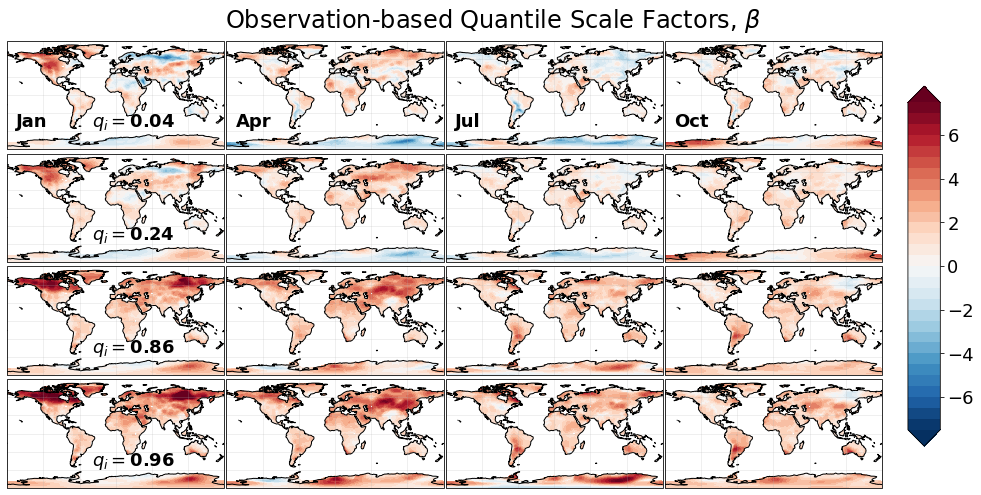

In [49]:
# set up things for the plot
fig=plt.figure(figsize=(18,10))
monstr2=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

# initialize the plot counter
pnum=0

# loop over the quantiles we want to plot
for qi,qq in enumerate(qplot):
    
    # loop over all of the months
    for mi in monthsi:

        # skip this iteration if we don't want to plot it
        if mi not in mplot:
            continue
        # else subselect the data
        beta_p=qxx_beta['beta'].sel(quantile=qq,month=mi)
                
        # wrap around the prime meridian before plotting
        beta_p_cyc = util.xr_add_cyclic_point(beta_p, 'lon')

        # plot the result
        pnum=pnum+1
        ax = plt.subplot(4, 4, pnum, projection=ccrs.PlateCarree())

        levs=np.arange(-7.5,7.5+0.5,0.5)
        datp=ax.contourf(beta_p_cyc.lon,beta_p_cyc.lat,beta_p_cyc, \
                          levels=levs, transform=ccrs.PlateCarree(),cmap='RdBu_r', \
                          extend='both')

        ax.coastlines()
        ax.gridlines(alpha=0.25)

        plt.xlabel('Longitude')
        plt.ylabel('Latitude')

        # add the month string
        if mi==1 and qi==0:
            plt.text(-165,-53,monstr2[mi-1],fontsize=18,fontweight='bold',transform=ccrs.PlateCarree())
            plt.text(-40,-53,'$q_i=$'+str(qq),fontsize=18,fontweight='bold',transform=ccrs.PlateCarree())
        elif mi!=1 and qi==0:
            plt.text(-165,-53,monstr2[mi-1],fontsize=18,fontweight='bold',transform=ccrs.PlateCarree())
        elif mi==1 and qi!=0:
             plt.text(-40,-53,'$q_i=$'+str(qq),fontsize=18,fontweight='bold',transform=ccrs.PlateCarree())
    
# adjust the white space between the subplots
plt.subplots_adjust(wspace=0.01, hspace=-0.45)

# make a single large colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.25, 0.025, 0.5])
ticklabs = cbar_ax.get_yticklabels()
cbar_ax.set_yticklabels(ticklabs, fontsize=18)
fig.colorbar(datp, cax=cbar_ax)

# write the full figure's title
plt.suptitle(r'Observation-based Quantile Scale Factors, $\beta$', fontsize=24, y=0.86)

plt.show()

# save the plot out
plot_save_name='figS4.pdf'
fig.savefig(fig_si_savepath+plot_save_name, dpi=300, bbox_inches='tight')